Sure, I'll break down the process into individual cells without defining functions.

### Cell 1: Import Libraries


In [12]:
import pickle
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')



### Cell 2: Load Pickle Files


In [4]:
# Load the TF-IDF vectorized matrices
with open('X_train_tfidf.pkl', 'rb') as f:
    X_train_tfidf = pickle.load(f)
with open('X_cv_tfidf.pkl', 'rb') as f:
    X_cv_tfidf = pickle.load(f)
with open('X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)
    
    
# Load the y datasets from local files
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('y_cv.pkl', 'rb') as f:
    y_cv = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)   



### Cell 3: Apply SMOTE


In [5]:
# Assuming y_train, y_cv, and y_test are already defined
smote = SMOTE(random_state=42)

print("Applying SMOTE to training data...")
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
print("Training data resampled.")

print("Applying SMOTE to cross-validation data...")
X_cv_tfidf_resampled, y_cv_resampled = smote.fit_resample(X_cv_tfidf, y_cv)
print("Cross-validation data resampled.")

print("Applying SMOTE to test data...")
X_test_tfidf_resampled, y_test_resampled = smote.fit_resample(X_test_tfidf, y_test)
print("Test data resampled.")

Applying SMOTE to training data...
Training data resampled.
Applying SMOTE to cross-validation data...
Cross-validation data resampled.
Applying SMOTE to test data...
Test data resampled.




### Cell 4: Perform Random Search CV


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),  # Ensures values between 0.01 and 0.3
    'subsample': uniform(0.7, 0.3),  # Ensures values between 0.7 and 1.0
    'colsample_bytree': uniform(0.7, 0.3)  # Ensures values between 0.7 and 1.0
}
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, verbosity=0), 
                                   param_distributions=param_dist, 
                                   n_iter=50, 
                                   cv=stratified_kfold, 
                                   n_jobs=-1, 
                                   verbose=3, 
                                   scoring='accuracy', 
                                   random_state=42)
print("Starting Random Search CV...")
random_search.fit(X_cv_tfidf_resampled, y_cv_resampled)
best_params = random_search.best_params_
cv_scores = random_search.cv_results_['mean_test_score']
print("Random Search CV completed.")
print("Best Parameters:", best_params)

Starting Random Search CV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Random Search CV completed.
Best Parameters: {'colsample_bytree': 0.7976199094477803, 'learning_rate': 0.226482507484227, 'max_depth': 9, 'n_estimators': 194, 'subsample': 0.7924182375557167}




### Cell 5: Train Model


In [8]:
print("Training XGBoost model with best parameters...")
xgboost = XGBClassifier(n_estimators=best_params['n_estimators'], 
                        max_depth=best_params['max_depth'], 
                        learning_rate=best_params['learning_rate'], 
                        subsample=best_params['subsample'],
                        colsample_bytree=best_params['colsample_bytree'],
                        use_label_encoder=False, 
                        verbosity=1)
xgboost.fit(X_train_tfidf_resampled, y_train_resampled)
print("Training completed.")

Training XGBoost model with best parameters...
Training completed.




### Cell 6: Test and Evaluate Model


In [13]:
print("Evaluating the model on test data...")
y_pred = xgboost.predict(X_test_tfidf_resampled)
y_pred_proba = xgboost.predict_proba(X_test_tfidf_resampled)[:, 1]

accuracy = accuracy_score(y_test_resampled, y_pred)
cm = confusion_matrix(y_test_resampled, y_pred)
report = classification_report(y_test_resampled, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test_resampled, y_pred_proba)

print("Evaluation completed.")
print("Accuracy:", accuracy)
print("Classification Report:", classification_report(y_test_resampled, y_pred))
print("ROC AUC Score:", roc_auc)

Evaluating the model on test data...
Evaluation completed.
Accuracy: 0.9271388824484118
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.91      0.93     60382
           1       0.91      0.95      0.93     60382

    accuracy                           0.93    120764
   macro avg       0.93      0.93      0.93    120764
weighted avg       0.93      0.93      0.93    120764

ROC AUC Score: 0.979793868918952




### Cell 7: Display Results


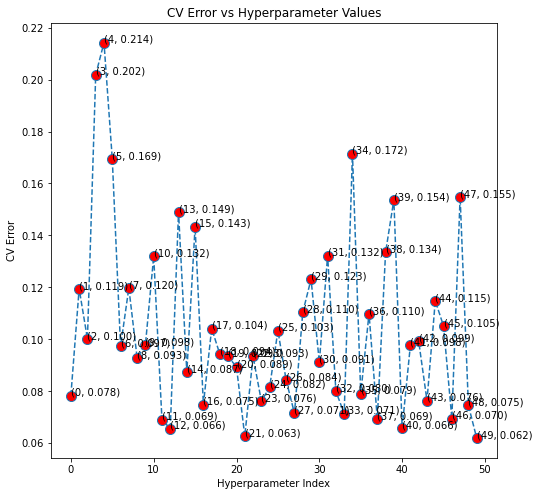

In [14]:
mse = [1 - x for x in cv_scores]
plt.figure(figsize=(8, 8))
plt.plot(range(len(cv_scores)), mse, linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
for i, (param, score) in enumerate(zip(range(len(cv_scores)), mse)):
    plt.annotate(f'({param}, {score:.3f})', (i, score), textcoords='data')
plt.title('CV Error vs Hyperparameter Values')
plt.xlabel('Hyperparameter Index')
plt.ylabel('CV Error')
plt.show()



This should cover the entire process step-by-step in individual cells, from importing libraries to displaying results.

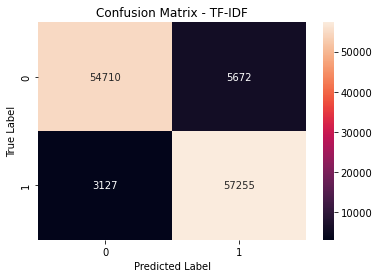

In [17]:
# Confusion Matrix
class_labels = np.unique(y_test_resampled)
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True, fmt="d")
plt.title("Confusion Matrix - TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



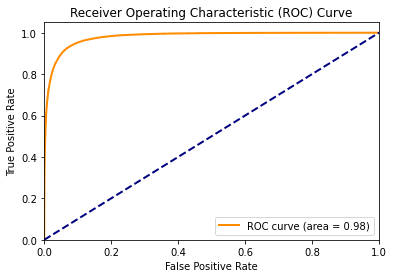

In [21]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_resampled, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
from tabulate import tabulate

# Classification Report as Table
report_df = pd.DataFrame(report).transpose()
report_table = tabulate(report_df, headers='keys', tablefmt='pretty')

print("Classification Report:")
print(report_table)

# Print Accuracy Percentage
accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|      0       | 0.9459342635337241 | 0.9060647212745521 | 0.9255703397930959 |      60382.0       |
|      1       | 0.9098638104470259 | 0.9482130436222715 | 0.9286426781500133 |      60382.0       |
|   accuracy   | 0.9271388824484118 | 0.9271388824484118 | 0.9271388824484118 | 0.9271388824484118 |
|  macro avg   | 0.927899036990375  | 0.9271388824484118 | 0.9271065089715547 |      120764.0      |
| weighted avg | 0.927899036990375  | 0.9271388824484118 | 0.9271065089715546 |      120764.0      |
+--------------+--------------------+--------------------+--------------------+--------------------+
Accuracy: 92.71%
